In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import os
import sys
from collections import Counter
import gget
import scipy
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer

import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from importlib import reload

# local imports
sys.path.append("./")
import utils

# Load our data

In [2]:
# fpath = "/scratch/indikar_root/indikar1/cstansbu/all_scHSC_run3/scanpy/anndata_distance.h5ad"
# fpath = "/scratch/indikar_root/indikar1/cstansbu/all_scHSC_run4/scanpy/anndata_distance.h5ad"
# fpath = "/scratch/indikar_root/indikar1/cstansbu/all_HSC/scanpy/anndata_distance.h5ad"
fpath = "/scratch/indikar_root/indikar1/cstansbu/all_HSC/scanpy/anndata_tabula_merged.h5ad"

adata = sc.read_h5ad(fpath)
adata.var_names_make_unique()

# annotate all labels
adata.obs['group'] = np.where(adata.obs['cluster_name'].isna(), "C5", adata.obs['cluster_name'])
adata.obs['group'] = np.where(adata.obs['celltype'] == 'HSC', "C6", adata.obs['group'])

adata

AnnData object with n_obs × n_vars = 35821 × 14420
    obs: 'cluster_name', 'set', 'organ_tissue', 'celltype', 'group'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p'
    layers: 'batch_corrected', 'normalized_log1p', 'raw_counts'

In [3]:
adata.obs['group'].value_counts(dropna=False)

C5    26586
C1     5559
C2     1442
C3      916
C6      760
C4      558
Name: group, dtype: int64

# PCA on all genes

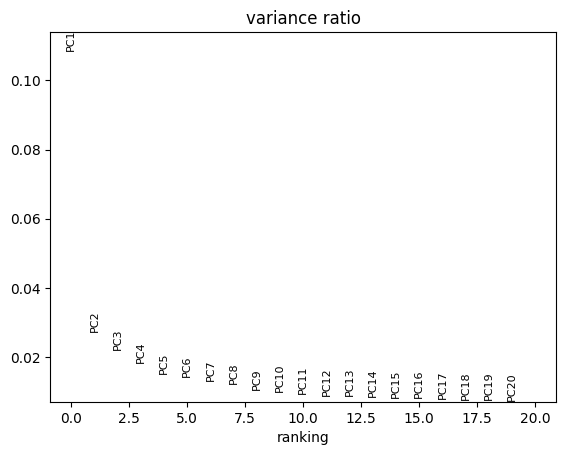

In [4]:
# conduct PCA
pdf = utils.get_stacked_cell_data(adata, genes='marker')

n_comps = 20
sc.tl.pca(pdf, n_comps=n_comps, use_highly_variable=False)
sc.pl.pca_variance_ratio(pdf, n_pcs=n_comps)

n_pca=2...
X.shape=(16950, 2)
n_pca=3...
X.shape=(16950, 3)
n_pca=4...
X.shape=(16950, 4)
n_pca=5...
X.shape=(16950, 5)
n_pca=6...
X.shape=(16950, 6)
n_pca=7...
X.shape=(16950, 7)
n_pca=8...
X.shape=(16950, 8)
n_pca=9...
X.shape=(16950, 9)
n_pca=10...
X.shape=(16950, 10)
n_pca=11...
X.shape=(16950, 11)
n_pca=12...
X.shape=(16950, 12)
n_pca=13...
X.shape=(16950, 13)
n_pca=14...
X.shape=(16950, 14)
n_pca=15...
X.shape=(16950, 15)
n_pca=16...
X.shape=(16950, 16)
n_pca=17...
X.shape=(16950, 17)
n_pca=18...
X.shape=(16950, 18)
n_pca=19...
X.shape=(16950, 19)


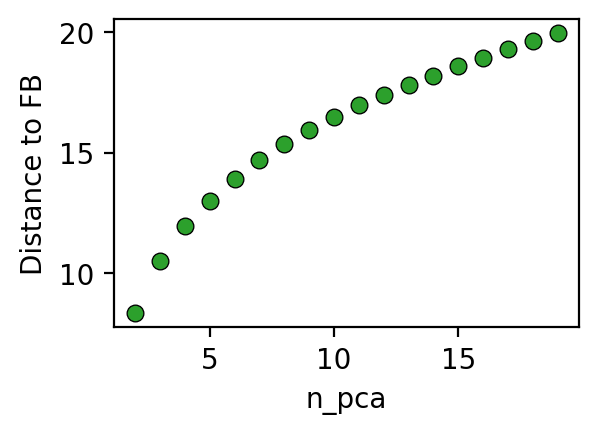

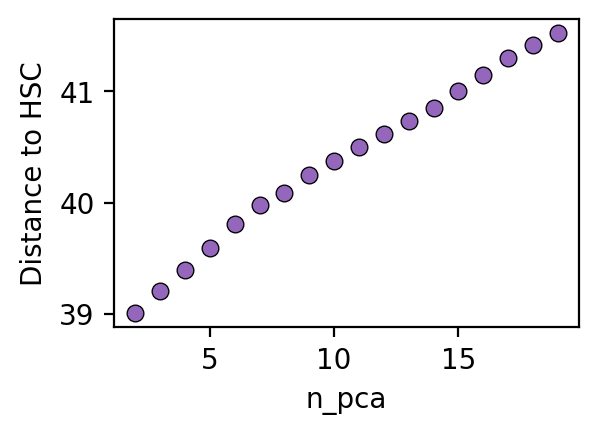

In [7]:
res = []
metric = 'euclidean'

our_cells_idx = pdf.obs[pdf.obs['set'] == 'our_data'].index
ref_fb_idx = pdf.obs[pdf.obs['group'] == 'C5'].index
ref_hsc_idx = pdf.obs[pdf.obs['group'] == 'C6'].index

for n_pca in np.arange(2, n_comps).astype(int):
    print(f"{n_pca=}...")
    X = pdf.obsm['X_pca'][:, 0:n_pca]
    print(f"{X.shape=}")

    # make distance matrix
    D = scipy.spatial.distance.pdist(X, metric=metric)
    D = scipy.spatial.distance.squareform(D)
    D = pd.DataFrame(D, index=pdf.obs.index, 
                     columns=pdf.obs.index)

    d2_fb = D.loc[our_cells_idx][ref_fb_idx].to_numpy()
    d2_hsc = D.loc[our_cells_idx][ref_hsc_idx].to_numpy()

    row = {
        'n_pca' : n_pca,
        'Distance to FB' : np.mean(d2_fb),
        'Distance to HSC' : np.mean(d2_hsc),
    }
    res.append(row)

res = pd.DataFrame(res)
res.head()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 2

sns.scatterplot(data=res, 
                x='n_pca',
                y='Distance to FB',
                color='C2',
                ec='k')
plt.show()

sns.scatterplot(data=res, 
                x='n_pca',
                y='Distance to HSC',
                color='C4',
                ec='k')
plt.show()

In [6]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# distances in PCA space

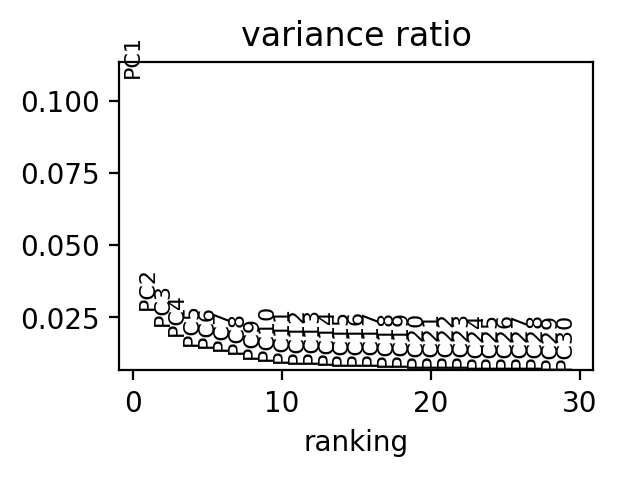

X.shape=(16950, 5)
C1
C2
C3
C4
C5


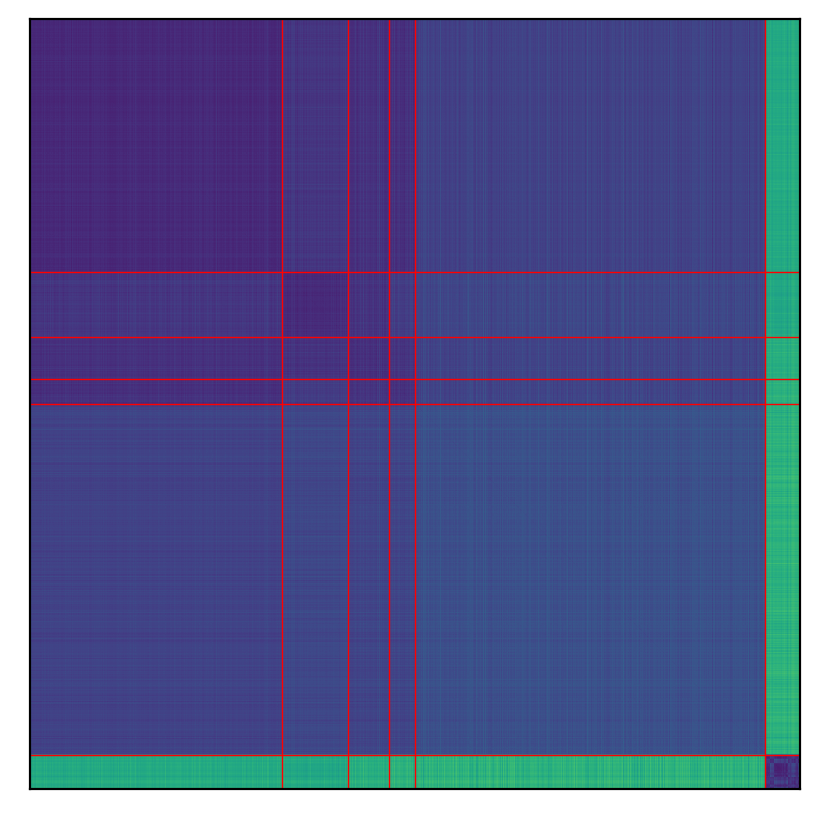

In [9]:
# conduct PCA
metric = 'euclidean'
n_comps = 30
use_n_pca = 5

pdf = utils.get_stacked_cell_data(adata, genes='marker')
sc.tl.pca(pdf, n_comps=n_comps, 
          use_highly_variable=False)

sc.pl.pca_variance_ratio(pdf, n_pcs=n_comps)

X = pdf.obsm['X_pca'][:, 0:use_n_pca]
print(f"{X.shape=}")

# make distance matrix
D = scipy.spatial.distance.pdist(X, metric=metric)
D = scipy.spatial.distance.squareform(D)
D = pd.DataFrame(D, index=pdf.obs.index, 
                 columns=pdf.obs.index)

sorted_idx = pdf.obs.sort_values(by='group').index
group_labels = pdf.obs['group'].sort_values().values
label_switch_idx = np.where(group_labels[:-1] != group_labels[1:])[0]
group_labels_unique = np.unique(group_labels)

D = D[sorted_idx]
D = D.reindex(sorted_idx)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

plt.imshow(D)
plt.xticks([], [])
plt.yticks([], [])

for i, idx_val in enumerate(label_switch_idx):
    print(group_labels_unique[i])
    plt.axvline(x=idx_val, c='r', lw=0.5)
    plt.axhline(y=idx_val, c='r', lw=0.5)

In [ ]:
# average distances
res = []

for i_name, group_i in pdf.obs.groupby('group'):
    for j_name, group_j in pdf.obs.groupby('group'):
        i_idx = group_i.index
        j_idx = group_j.index

        mean_dist = np.mean(D.loc[i_idx][j_idx].to_numpy())

        row = {
            'i_name' : i_name,
            'j_name' : j_name,
            'mean_dist' : mean_dist,
        }

        res.append(row)
        
res = pd.DataFrame(res)
res = pd.pivot_table(res, 
                     index='i_name', 
                     columns='j_name', 
                     values='mean_dist')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(res, square=True,
            linewidth=0.5,
            annot=True,
            fmt=".1f",
            cbar=False)

plt.ylabel("")
plt.xlabel("")
plt.gca().tick_params(axis='y', rotation=0)
plt.title("Mean Distance in PCA Coordinates")